In [ ]:
import numpy as np
import pandas as pd
import io
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import string
import re
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# GET the data
## Mounting path dari Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Memuat Data
import pandas as pd

dataset = pd.read_csv("/content/drive/My Drive/Dataset/output.csv", usecols=["Tweet"])

In [ ]:
# EXPLORE the data
## Menampilkan lima data terakhir
dataset.tail()

,Tweet
1880,kabur tanggung kemas calon capres jokowi
1881,berani pmrntah m g da yg d arepin klo dh ganti...
1882,anak medan dukung capres jk md ckp putar
1883,jelek komposisi udah bagus prabowo sbg preside...
1884,langsung deh ngadu capres hatta rajasa biar pa...


In [ ]:
# MODEL the data
## Pra Pengolahan - Cleaning
"""
import numpy as np
import re

def clean_text(tweet):

    # Convert to lower case
    tweet = tweet.lower()
    # remove unicode characters
    tweet = tweet.encode('ascii', 'ignore').decode()
    # Clean www.* or https?://*
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    # Clean @username
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    #Replace #word with word
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    #trim
    tweet = tweet.strip('\'"')

    return tweet

dataset["Isi_Tweet"] = dataset['Isi_Tweet'].map(lambda x: clean_text(x))
dataset = dataset[dataset['Isi_Tweet'].apply(lambda x: len(x.split()) >=1)]

print(dataset.shape)
"""

'\nimport numpy as np\nimport re\n\ndef clean_text(tweet):\n    \n    # Convert to lower case\n    tweet = tweet.lower()\n    # remove unicode characters\n    tweet = tweet.encode(\'ascii\', \'ignore\').decode()\n    # Clean www.* or https?://*\n    tweet = re.sub(\'((www\\.[^\\s]+)|(https?://[^\\s]+))\',\'\',tweet)\n    # Clean @username\n    tweet = re.sub(\'@[^\\s]+\',\'\',tweet)\n    #Remove additional white spaces\n    tweet = re.sub(\'[\\s]+\', \' \', tweet)\n    #Replace #word with word\n    tweet = re.sub(r\'#([^\\s]+)\', r\'\x01\', tweet)\n    #trim\n    tweet = tweet.strip(\'\'"\')\n    \n    return tweet\n\ndataset["Isi_Tweet"] = dataset[\'Isi_Tweet\'].map(lambda x: clean_text(x))\ndataset = dataset[dataset[\'Isi_Tweet\'].apply(lambda x: len(x.split()) >=1)]\n\nprint(dataset.shape)\n'

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.7 MB/s eta 0:00:00


In [ ]:
## Pra Pengolahan - Representasi Data
from transformers import AutoTokenizer, TFAutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
bert_model = TFAutoModel.from_pretrained("indobenchmark/indobert-base-p2", trainable=False)

def tokenisasi(teks):
    encode_dict = bert_tokenizer(teks,
                                   add_special_tokens = True,
                                   max_length = 128,
                                   padding = 'max_length',
                                   truncation = True,
                                   return_attention_mask = True,
                                   return_tensors = 'tf',)

    tokenID = encode_dict['input_ids']
    attention_mask = encode_dict['attention_mask']

    return tokenID, attention_mask
    return tokenID

def bert(data):
    emb = []
    for teks in data:
        #print(teks)
        token, mask = tokenisasi(str(teks))
        emb.append(bert_model([token, mask])[1].numpy().tolist()[0])

    return emb

### BERT Embedding
bert_emb = np.array(bert(dataset.to_numpy()))

print(bert_emb.shape)

Some layers from the model checkpoint at indobenchmark/indobert-base-p2 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at indobenchmark/indobert-base-p2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


(1885, 768)


In [ ]:
## Model EFCM - Reduksi Dimensi
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 5)
data = svd.fit_transform(bert_emb)

print(data.shape)

(1885, 5)


In [ ]:
## Model EFCM - Clustering
from sklearn.cluster import KMeans
import sys
sys.path.insert(0, "/content/drive/My Drive/Topic Detection/FCMeans")
from fcmeans import fcmeans

m = 0.1
n_topics = 3
initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
cluster_membership = np.argmax(u, axis=0)

print(cluster_membership.shape)

(1885,)


In [ ]:
### Topic Interpretation
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

#### Class Based TFIDF (C-TFIDF) Functions
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

def extract_top_words_per_topic(tf_idf, count, docs_per_topic, n = 10):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    top_words = []
    for i in range(len(labels)):
      top_words.append([words[j] for j in indices [i]][::-1])
    return top_words

#### Topic Representation
docs = pd.DataFrame(list(dataset["Tweet"]), columns=["Doc"])
docs['Topic'] = cluster_membership
docs['Doc_ID'] = range(len(docs))
docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)
print(top_words)

[['yg', 'jd', 'capres', 'jokowi', 'arb', 'rt', 'presiden', 'ya', 'jk', 'aja'], ['prabowo', 'hatta', 'wakil', 'presiden', 'kalla', 'capres', 'jokowi', 'jusuf', 'cawapres', 'ketua']]


In [ ]:
### Topic Coherence
import gensim
from itertools import combinations
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Memuat Model Word2Vec
w2v_model = gensim.models.Word2Vec.load("/content/drive/My Drive/Topic Detection/word2vec/idwiki-berita/w2v-model.bin")

### Fungsi Menghitung Coherence
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            if pair[0] in w2v_model.wv.vocab:
                if pair[1] in w2v_model.wv.vocab:
                    pair_scores.append( abs(w2v_model.wv.similarity(pair[0], pair[1])) )
                #else:
                    #pair_scores.append(0)
            #else:
                #pair_scores.append(0)

        # get the mean for all pairs in this topic
        if pair_scores:
            topic_score = sum(pair_scores) / len(pair_scores)
            overall_coherence += topic_score

    # get the mean score across all topics
    return overall_coherence / len(term_rankings)


### Menentukan Nilai Coherence dari Topik
print(calculate_coherence(w2v_model, top_words))

0.3005494765937328


The number of topics is 1
The simulation 1
Coherence value :  0.24421348422765732
The simulation 2
Coherence value :  0.24421348422765732
The simulation 3
Coherence value :  0.24421348422765732
The simulation 4
Coherence value :  0.24421348422765732
The simulation 5
Coherence value :  0.24421348422765732
The simulation 6
Coherence value :  0.24421348422765732
The simulation 7
Coherence value :  0.24421348422765732
The simulation 8
Coherence value :  0.24421348422765732
The simulation 9
Coherence value :  0.24421348422765732
The number of topics is 2
The simulation 1
Coherence value :  0.3005494765937328
The simulation 2
Coherence value :  0.3005494765937328
The simulation 3
Coherence value :  0.3005494765937328
The simulation 4
Coherence value :  0.3005494765937328
The simulation 5
Coherence value :  0.3005494765937328
The simulation 6
Coherence value :  0.3005494765937328
The simulation 7
Coherence value :  0.3005494765937328
The simulation 8
Coherence value :  0.3005494765937328
The 

Text(0, 0.5, 'Coherence')

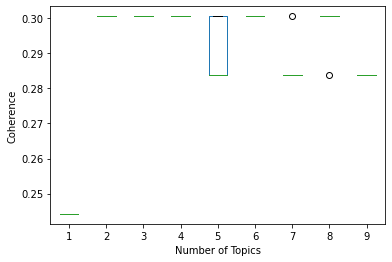

In [ ]:
## Parameter Tuning
### Jumlah Topik Optimal
import pandas as pd

num_topics = []
coherences = []
for n_topics in range(1,10,1):
    print("The number of topics is " + str(n_topics))

    coherence_sim = []
    for i in range(1,10,1):
        print("The simulation " + str(i))

        #topic detection
        m = 0.5
        initkm = KMeans(n_clusters=n_topics, n_init=1).fit(data)
        cntr, u = fcmeans(data.T, n_topics, m, error=0.0001, maxiter=200, init=initkm.cluster_centers_.T)
        cluster_membership = np.argmax(u, axis=0)

        docs = pd.DataFrame(list(dataset["Tweet"]), columns=["Doc"])
        docs['Topic'] = cluster_membership
        docs['Doc_ID'] = range(len(docs))
        docs_per_topic = docs.dropna(subset=['Doc']).groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

        tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(docs))
        top_words = extract_top_words_per_topic(tf_idf, count, docs_per_topic, 10)

        coherence_sim.append(calculate_coherence(w2v_model, top_words))
        print('Coherence value : ',coherence_sim[i-1])

    num_topics.append(n_topics)
    coherences.append(coherence_sim)

### Visualisasi
df = pd.DataFrame.from_records(coherences).T
df.columns = num_topics
boxplot = df.boxplot(grid=False)
boxplot.set_xlabel("Number of Topics")
boxplot.set_ylabel("Coherence")